

# 项目：预约挂号实际就诊情况数据分析


## 目录
<ul>
<li><a href="#intro">简介</a></li>
<li><a href="#wrangling">数据整理</a></li>
<li><a href="#eda">探索性数据分析</a></li>
<li><a href="#conclusions">结论</a></li>
</ul>

<a id='intro'></a>
## 简介


医疗是与每个人息息相关的话题，在这个人口众多、快节奏的社会，提高医疗服务质量，构建和谐的医患关系十分重要。挂号预约是个非常便民的服务，可是由于一些病人的爽约，导致医疗资源的闲置而拖延了其他患者的就诊时间。针对爽约患者的特征进行研究，有助于预测患者是否按时预约。对于今后规范挂号预约流程、采取措施提高服务质量和效率十分重要。

此次研究采用包含10万条巴西预约挂号的求诊信息（数据来源：Kaggle），研究病人是否如约前往医院就诊，每行数据录入了有关患者特点的多个数值。数据集包含信息如下：

1. PatientId：病人ID
2. AppointmentID：预约ID
3. Gender：男性或女性。其中女性占据大部分比例，相比于男性而言女性更关心自己的身体健康。
4. ScheduledDay：预约日期
5. ScheduledDay：就诊日期
6. age：年龄
7. Neighbourhood：预约医院地点
8. Scholarship：福利保障
9. Hipertension：高血压
10. Diabetes：糖尿病
11. Alcoholism：酗酒
12. Handcap：残疾人士
13. SMS_received：是否收到信息，0表示没有收到短信，1表示收到短信
14. No-show：爽约

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


<a id='wrangling'></a>
## 数据整理


### 常规属性

In [5]:
# 加载数据并打印两行查看数据内容
df = pd.read_csv('noshowappointments-kagglev2-may-2016.csv')
df.head(2)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No


In [6]:
df.shape #查看数据的形状

(110527, 14)

In [7]:
#查看是否重复数据
df.duplicated().sum()

0

**无重复数据**

In [8]:
# 查看数据类型，以及是否有缺失数据或错误数据的情况
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


**无缺失值**


### 数据清理

### 1、ScheduledDay和AppointmentDay应用to_datetime()方法转换为datetime格式，并算出从预约到赴约的时间间隔。

In [9]:
#把ScheduledDay和AppointmentDay转换为datetime格式
df['ScheduledDay']=pd.to_datetime(df['ScheduledDay'])
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])

#算出时间间隔
df['TimeSpan']=df['AppointmentDay']-df['ScheduledDay']
df['TimeSpan']=df['TimeSpan'].apply(lambda x:x.days)

#查看TimeSpan的信息
df['TimeSpan'].describe()

count    110527.000000
mean          9.183702
std          15.254996
min          -7.000000
25%          -1.000000
50%           3.000000
75%          14.000000
max         178.000000
Name: TimeSpan, dtype: float64

In [10]:
#当天赴约的值应该为-1、0，然而这里最小值为-7，需要进行筛选
df=df.query('TimeSpan>=-1')
#再次检查TimeSpan的信息
df['TimeSpan'].describe()

count    110522.000000
mean          9.184253
std          15.255115
min          -1.000000
25%          -1.000000
50%           3.000000
75%          14.000000
max         178.000000
Name: TimeSpan, dtype: float64

In [11]:
#使用cut函数，创建Waiting列
label=['AtOnce','OneDay','OneWeek','TwoWeeks','OneMonth','>OneMonth']   #时间区间标签
array=[-2,0,1,7,14,30,178]  #分隔边缘array
df['Waiting']=pd.cut(df['TimeSpan'],array,labels=label) #将年龄段进行分割

### 2、由于年龄数据较为离散，将年龄分段：0-17岁为未成年人，18-35岁为青年人，35-65位中年人，65岁以上为老年人

In [12]:
df['Age'].describe()

count    110522.000000
mean         37.089041
std          23.110064
min          -1.000000
25%          18.000000
50%          37.000000
75%          55.000000
max         115.000000
Name: Age, dtype: float64

In [13]:
#最小年龄为-1，需要清除异常值
df=df.query('Age>=0')

In [14]:
#将年龄段进行划分
label=['juvenile','youth','middle-aged','elderly']   #年龄段标签
edge_bin=[-1,17,35,65,116]   #年龄分隔边缘
df['Generation'] = pd.cut(df['Age'],edge_bin,labels=label)
df['Generation']

0         middle-aged
1         middle-aged
2         middle-aged
3            juvenile
4         middle-aged
             ...     
110522    middle-aged
110523    middle-aged
110524          youth
110525    middle-aged
110526    middle-aged
Name: Generation, Length: 110521, dtype: category
Categories (4, object): [juvenile < youth < middle-aged < elderly]

### 3.列名规范：No—show：No_show，Handcap：Handicap，AppointmentID：AppointmentId

In [15]:
df.rename(columns={'AppointmentID':'AppointmentId', 'Handcap':'Handicap', 'No-show':'No_show'}, inplace=True)

#再次查看列，审核清理的数据
df.head(5)

,PatientId,AppointmentId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handicap,SMS_received,No_show,TimeSpan,Waiting,Generation
0,2.987250e+13,5642903,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,0,1,0,0,0,0,No,-1,AtOnce,middle-aged
1,5.589978e+14,5642503,M,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,0,0,0,0,0,No,-1,AtOnce,middle-aged
2,4.262962e+12,5642549,F,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,MATA DA PRAIA,0,0,0,0,0,0,No,-1,AtOnce,middle-aged
3,8.679512e+11,5642828,F,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,-1,AtOnce,juvenile
4,8.841186e+12,5642494,F,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,1,1,0,0,0,No,-1,AtOnce,middle-aged


<a id='eda'></a>
## 探索性数据分析


### 研究问题 1 较长的等待时间是否会影响赴约就诊？

In [16]:
#计算不同情况下的爽约比例函数
def proportion(column):
    no_show_counts = df.query('No_show == "Yes"').groupby(column)['No_show'].count()#算出指定列不同条件下未就诊人数
    total = df.groupby(column)['No_show'].count() #算出指定列不同条件下的总人数
    proportion = no_show_counts/total #算出比例
    return proportion

In [17]:
#不同等待时间下，爽约人数的比例
Waiting_P=proportion('Waiting')
Waiting_P

Waiting
AtOnce       0.066362
OneDay       0.238216
OneWeek      0.253643
TwoWeeks     0.312254
OneMonth     0.325212
>OneMonth    0.330208
Name: No_show, dtype: float64

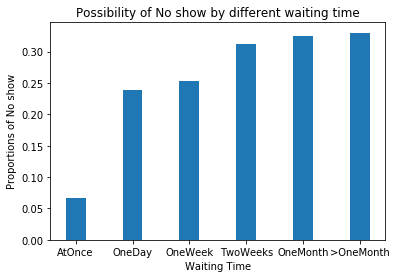

In [18]:
#在柱状图上绘制比例
# 绘制条柱
proportion_bars = plt.bar(np.arange(len(Waiting_P)),Waiting_P,0.35)
plt.ylabel('Proportions of No show')
plt.xlabel('Waiting Time')
plt.title('Possibility of No show by different waiting time')
plt.xticks(np.arange(len(Waiting_P)),Waiting_P.index.tolist());


### 由上述可以看出，随着等待时间的增加，爽约的比例就越高。当天预约的人准时就诊的概率远高于其他的情况。

### 研究问题 2 不同年龄段的病人按时赴约的情况

In [19]:
#不同年龄段下爽约的比例
Generation_P=proportion('Generation')
Generation_P

Generation
juvenile       0.219008
youth          0.238116
middle-aged    0.184347
elderly        0.155263
Name: No_show, dtype: float64

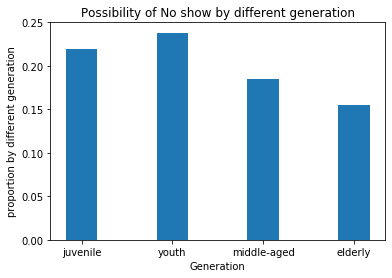

In [20]:
#进行可视化分析
Proportion_bar = plt.bar(np.arange(len(Generation_P)),Generation_P,0.35)
plt.ylabel('proportion by different generation')
plt.xlabel('Generation')
plt.title('Possibility of No show by different generation')
plt.xticks(np.arange(len(Generation_P)),Generation_P.index.tolist());

### 由上述图可以看出，青年人和未成年人的爽约比例要大于中年人和老年人。中老年人按时就诊的可能性最高。

### 研究问题 3  收到短信是否会增加纠正率

In [21]:
#计算是否收到短信爽约的比例
SMS_P=proportion('SMS_received')
SMS_P

SMS_received
0    0.166980
1    0.275745
Name: No_show, dtype: float64

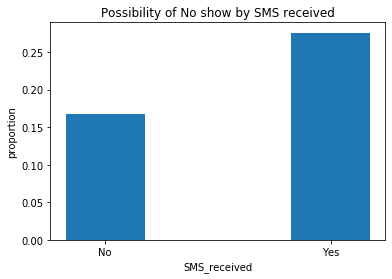

In [22]:
#可视化比例
proportion_bar = plt.bar(np.arange(len(SMS_P)),SMS_P,0.35)
plt.xlabel('SMS_received')
plt.ylabel('proportion')
plt.title('Possibility of No show by SMS received')
plt.xticks(np.arange(len(SMS_P)),['No','Yes']);

### 可以看出收到短信的患者失约的比例更多，说明短信对于如约就诊没有帮助

### 研究问题3  不同疾病的年龄分布

In [23]:
#统计不同年龄段患各类的疾病数
desease = df.groupby('Generation').sum()

desease

,PatientId,AppointmentId,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handicap,SMS_received,TimeSpan
Generation,,,,,,,,,,
juvenile,4.080032e+18,155418086093,200767,3062,38,51,24,286,8021,235661
youth,3.701380e+18,145423276715,680292,3380,810,226,448,423,8729,228860
middle-aged,6.598740e+18,250962168288,2224486,4168,12969,4559,2579,1063,14734,413931
elderly,1.920660e+18,75436740406,993611,251,7984,3107,309,685,3998,136611


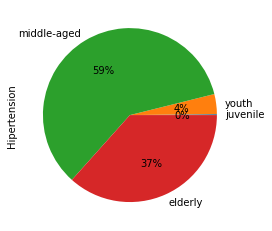

In [24]:
#绘制饼状图
Hipertension_pie=desease.Hipertension.plot(kind = 'pie',autopct='%.0f%%');


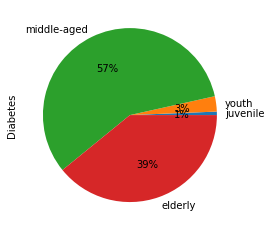

In [25]:
Diabetes_pie = desease.Diabetes.plot(kind = 'pie',autopct='%.0f%%');

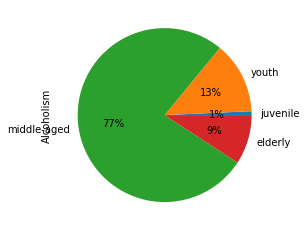

In [26]:
Alcoholism = desease.Alcoholism	.plot(kind = 'pie',autopct='%.0f%%');

### 可以看出这三种疾病患者的比例全部都是中年人最多，其中酗酒中年人所占比例远远超过其他年龄段。三种疾病未成年人患者最少。虽然高血压和糖尿病，老人患者的比例大于青年人，但是酗酒方面青年人比例占上风。

<a id='conclusions'></a>
## 结论
### 1、随着等待时间的增加，爽约的比例就越高。当天预约的人准时就诊的概率远高于其他的情况。
### 2、青年人和未成年人的爽约比例要大于中年人和老年人。中老年人按时就诊的可能性最高。
### 3、短信对于如约就诊没有帮助
### 4、患高血压、糖尿病、酗酒的人群中，中年人比例全部是最多的。酗酒人群中，中年人远超过其他年龄段。未成年人患这三种疾病的较少。虽然高血压和糖尿病患者，老年人多于中年人，但是青年人酗酒要比老年人严重。